In [6]:
%matplotlib inline
import numpy as np
import os
from evaluate_tools import evaluate,plot_confusion_matrix
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
cnn_prob_file='../result/cnn_prob.csv'
tscnn_prob_file='../result/tscnn_prob.csv'
yolo_prob_file='../result/yolo_prob.csv'
tsyolo_prob_file='../result/tsyolo_prob.csv'

In [7]:
def read_probs():
    probs={}
    
    with open(cnn_prob_file) as f:
        next(f)
        lines=f.readlines()
    for line in lines:
        data=line.replace("\n","").split(",")
        fn=data[0].split("/")[4].replace(".txt","").replace(".jpg","")
        if fn not in probs:
            probs[fn]={}
            probs[fn]["real"]=float(data[1])
        probs[fn]["cnn"]={}
        probs[fn]["cnn"]["prob"]=np.asarray([float(i) for i in data[2:5]])
        probs[fn]["cnn"]["result"]=np.argmax(probs[fn]["cnn"]["prob"])
            
    with open(tscnn_prob_file) as f:
        next(f)
        lines=f.readlines()
    for line in lines:
        data=line.replace("\n","").split(",")
        fn=data[0].split("/")[4].replace(".txt","").replace(".jpg","")
        if fn not in probs:
            probs[fn]={}
            probs[fn]["real"]=float(data[1])
        probs[fn]["tscnn"]={}
        probs[fn]["tscnn"]["prob"]=np.asarray([float(i) for i in data[2:5]])
        probs[fn]["tscnn"]["result"]=np.argmax(probs[fn]["tscnn"]["prob"])
    
    with open(yolo_prob_file) as f:
        next(f)
        lines=f.readlines()
    for line in lines:
        data=line.replace("\n","").split(",")
        fn=data[0].split("/")[4].replace(".txt","").replace(".jpg","")
        if fn not in probs:
            probs[fn]={}
            probs[fn]["real"]=float(data[1])
        probs[fn]["yolo"]={}
        probs[fn]["yolo"]["prob"]=np.asarray([float(i) for i in data[2:5]])
        probs[fn]["yolo"]["result"]=np.argmax(probs[fn]["yolo"]["prob"])
            
    with open(tsyolo_prob_file) as f:
        next(f)
        lines=f.readlines()
    for line in lines:
        data=line.replace("\n","").split(",")
        fn=data[0].split("/")[4].replace(".txt","").replace(".jpg","")
        if fn not in probs:
            probs[fn]={}
            probs[fn]["real"]=float(data[1])
        probs[fn]["tsyolo"]={}
        probs[fn]["tsyolo"]["prob"]=np.asarray([float(i) for i in data[2:5]])
        probs[fn]["tsyolo"]["result"]=np.argmax(probs[fn]["tsyolo"]["prob"])
    
    return probs

In [8]:
probs=read_probs()


SCOREs
+-------+-----------+--------+--------+---------+
| Label | Precision | Recall | FScore | Support |
+=======+===========+========+========+=========+
| 0     | 0.824     | 0.764  | 0.792  | 110     |
+-------+-----------+--------+--------+---------+
| 1     | 0.754     | 0.836  | 0.793  | 110     |
+-------+-----------+--------+--------+---------+
| 2     | 0.972     | 0.936  | 0.954  | 110     |
+-------+-----------+--------+--------+---------+


 CONFUSION MATRIX
[[0.76363636 0.23636364 0.        ]
 [0.13636364 0.83636364 0.02727273]
 [0.02727273 0.03636364 0.93636364]]


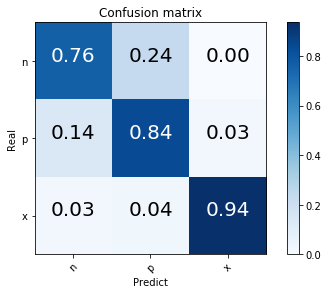

In [9]:
def voting_a(probs):
    true=[]
    pred=[]
    for k in sorted(probs,key=lambda k:probs[k]["real"]):
        true_value=probs[k]["real"]
        pred_value=[probs[k]["cnn"]["result"],probs[k]["tscnn"]["result"],probs[k]["yolo"]["result"],probs[k]["tsyolo"]["result"]]
        true.append(true_value)
        if pred_value.count(1)>=2:
            pred.append(1)
        elif pred_value.count(2)>=3:
            pred.append(2)
        else:
            pred.append(0)
    return np.asarray(true),np.asarray(pred)
t,p=voting_a(probs)
evaluate(t,p)
plot_confusion_matrix(t,p,["n","p","x"])


SCOREs
+-------+-----------+--------+--------+---------+
| Label | Precision | Recall | FScore | Support |
+=======+===========+========+========+=========+
| 0     | 0.857     | 0.764  | 0.808  | 110     |
+-------+-----------+--------+--------+---------+
| 1     | 0.754     | 0.836  | 0.793  | 110     |
+-------+-----------+--------+--------+---------+
| 2     | 0.964     | 0.964  | 0.964  | 110     |
+-------+-----------+--------+--------+---------+


 CONFUSION MATRIX
[[0.76363636 0.23636364 0.        ]
 [0.12727273 0.83636364 0.03636364]
 [0.         0.03636364 0.96363636]]


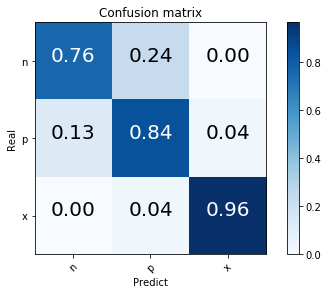

In [10]:
def voting_b(probs):
    true=[]
    pred=[]
    for k in sorted(probs,key=lambda k:probs[k]["real"]):
        true_value=probs[k]["real"]
        pred_value=[probs[k]["cnn"]["result"],probs[k]["tscnn"]["result"],probs[k]["yolo"]["result"],probs[k]["tsyolo"]["result"]]
        true.append(true_value)
        if pred_value.count(1)>=2:
            pred.append(1)
        elif pred_value.count(2)>=2:
            pred.append(2)
        else:
            pred.append(0)
    return np.asarray(true),np.asarray(pred)
t,p=voting_b(probs)
evaluate(t,p)
plot_confusion_matrix(t,p,["n","p","x"])